In [5]:
from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.request
import openai
import re
import matplotlib.pyplot as plt
import numpy as np
import os

# Helper Functions

In [6]:
openai.api_key = os.getenv("OPENAI_API_KEY")

def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    
    if str(element) == '\n':
        return False
    
    if str(element) == " ":
        return False
    
    return True


def text_from_html(body):
    soup = BeautifulSoup(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return texts, u" ".join(t.strip() for t in visible_texts)


def queryOracle(text):
    completion = openai.ChatCompletion.create(
    model = "gpt-3.5-turbo",
    temperature = 0.8,
    max_tokens = 2000,
    messages = [
        {"role": "system", "content": "You are a webpage analyzer. You find sections of text on an e-commerce webpage that correspond to navigation, page heading, buying selections and checkout options."},
        {"role": "user", "content": text}
    ]
    )

    return completion


def findOverlap(readableText, lines):
    text = ""
    for count, i in enumerate(lines):
        text += str(count) + ") " + i

    completion = openai.ChatCompletion.create(
    model = "gpt-3.5-turbo",
    temperature = 0.8,
    max_tokens = 2000,
    messages = [
        {"role": "system", "content": "You a text overlap analyzer. You find sections of a paragraph by giving the exact sequence of text that overlap most with a list of sentences."},
        {"role": "user", "content": "Paragraph: {}\n\n\n Sentences: {}".format(readableText, text)}
    ]
    )

    return completion

     

# Chunking Text using GPT

In [7]:
html = urllib.request.urlopen('https://boxbox.in/products/copy-of-boxbox-oversized-t-shirt-44-lewis-hamilton-1').read()
elements, readableText = text_from_html(html)
elements = list(filter(tag_visible, elements))
elements[0].parent
response = queryOracle(readableText).choices[0].message

/var/folders/8g/x9ncyhjj3wdchhjpvtkcr_640000gp/T/ipykernel_94764/3233034007.py:20: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  texts = soup.findAll(text=True)


In [8]:
sections = ["Navigation", "Page Heading", "Buying Selections", "Checkout Options"]


parts = []
inds = []
for count, i in enumerate(sections):
    p = response.content.find(i, 0)
    start = p+len(i)+1
    inds.append(p+len(i)+1)
    sub = response.content[start : len(response.content)]
    parts.append(sub)
    if (count > 0):
        parts[count-1] = parts[count-1][0: p - inds[count-1]]


parts

['\n- Home\n- Formula 1\n- Football\n- Contact\n- About Us\n- Blogs\n- Log in\n\n',
 '\n- Formula 1 T-shirts Oversized T-shirts Sweatshirts Hoodies\n\n',
 '\n- Oversized T-shirt Lewis Hamilton Sketch\n- Size options: S, M, L, XL\n- Color options: Black, White\n- Quantity selection\n\n',
 '\n- Add to cart\n- Refresh pickup availability\n\n']

# Manually Finding Text Overlap

In [9]:
overlaps = []
for i in parts:
    partMap = {}
    for j in i.split(','):
        print(j.strip())
        # partMap[j.strip()] = 
        # [m.start() for m in re.finditer(j.strip(), str(html))]
        # [i.start() for i in re.finditer(j.strip(), str(html))]
    # overlaps.append(partMap)


overlaps


- Home
- Formula 1
- Football
- Contact
- About Us
- Blogs
- Log in
- Formula 1 T-shirts Oversized T-shirts Sweatshirts Hoodies
- Oversized T-shirt Lewis Hamilton Sketch
- Size options: S
M
L
XL
- Color options: Black
White
- Quantity selection
- Add to cart
- Refresh pickup availability


[]

In [11]:
overlaps

[]

In [10]:
for i in overlaps[0]:
    plt.hist(overlaps[0][i])

plt.show()


IndexError: list index out of range

# Plagiarism Detector

In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
# nltk.download('all')

In [6]:
orig = str(html)
plag = parts[0]

tokens_o=word_tokenize(orig)
tokens_p=word_tokenize(plag)

#lowerCase
tokens_o = [token.lower() for token in tokens_o]
tokens_p = [token.lower() for token in tokens_p]

#stop word removal
#punctuation removal
stop_words=set(stopwords.words('english'))
punctuations=['"','.','(',')',',','?',';',':',"''",'``']
filtered_tokens_o = [w for w in tokens_o if not w in stop_words and not w in punctuations]
filtered_tokens_p = [w for w in tokens_p if not w in stop_words and not w in punctuations]

In [7]:
trigrams_o=[]
for i in range(len(tokens_o)-2):
    t=(tokens_o[i],tokens_o[i+1],tokens_o[i+2])
    trigrams_o.append(t)

s=0
trigrams_p=[]
for i in range(len(tokens_p)-2):
    t=(tokens_p[i],tokens_p[i+1],tokens_p[i+2])
    trigrams_p.append(t)
    if t in trigrams_o:
        s+=1

#jaccord coefficient = (S(o)^S(p))/(S(o) U S(p))
J=s/(len(trigrams_o)+len(trigrams_p)) 
print(J)

#containment measure
C=s/len(trigrams_p)
print(C)

0.0
0.0


In [8]:
def lcs_score(l1,l2):
    s1=word_tokenize(l1)
    s2=word_tokenize(l2)
    # storing the dp values 
    dp = [[None]*(len(s1)+1) for i in range(len(s2)+1)] 
  
    for i in range(len(s2)+1): 
        for j in range(len(s1)+1): 
            if i == 0 or j == 0: 
                dp[i][j] = 0
            elif s2[i-1] == s1[j-1]: 
                dp[i][j] = dp[i-1][j-1]+1
            else: 
                dp[i][j] = max(dp[i-1][j] , dp[i][j-1]) 
    return dp[len(s2)][len(s1)] 

In [9]:
sent_o=sent_tokenize(orig)
sent_p=sent_tokenize(plag)

#maximum length of LCS for a sentence in suspicious text
max_lcs=0
sum_lcs=0

for i in sent_p:
    for j in sent_o:
        l=lcs_score(i,j)
        max_lcs=max(max_lcs,l)
    sum_lcs+=max_lcs
    max_lcs=0

score=sum_lcs/len(tokens_p)
print(score)

0.5714285714285714


In [12]:
def lcs(X, Y, m, n):
    L = [[0 for i in range(n+1)] for j in range(m+1)]
 
    # Following steps build L[m+1][n+1] in bottom up fashion. Note
    # that L[i][j] contains length of LCS of X[0..i-1] and Y[0..j-1]
    for i in range(m+1):
        for j in range(n+1):
            if i == 0 or j == 0:
                L[i][j] = 0
            elif X[i-1] == Y[j-1]:
                L[i][j] = L[i-1][j-1] + 1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])
 
    # Create a string variable to store the lcs string
    lcs = ""
 
    # Start from the right-most-bottom-most corner and
    # one by one store characters in lcs[]
    i = m
    j = n
    inds = []
    while i > 0 and j > 0:
 
        # If current character in X[] and Y are same, then
        # current character is part of LCS
        if X[i-1] == Y[j-1]:
            lcs += X[i-1]
            inds.append(i-1)
            i -= 1
            j -= 1
 
        # If not same, then find the larger of two and
        # go in the direction of larger value
        elif L[i-1][j] > L[i][j-1]:
            i -= 1
             
        else:
            j -= 1
 
    # We traversed the table in reverse order
    # LCS is the reverse of what we got
    lcs = lcs[::-1]
    # print("LCS of " + X + " and " + Y + " is " + lcs)
    print("LCS is {}".format(lcs))
    for i in inds[::-1]:
        print(X[i], end = "")

    print("")
    print(inds[::-1])
    
    return inds[::-1] 
 
 
# Driver program
inds1 = lcs(orig, parts[0], len(orig), len(parts[0]))
inds2 = lcs(orig, parts[1], len(orig), len(parts[1]))
inds3 = lcs(orig, parts[2], len(orig), len(parts[2]))
inds4 = lcs(orig, parts[3], len(orig), len(parts[3]))



LCS is  - Home- Formula 1- Football- Contact- About Us- Blogs- Smiles- Log in- Cart
 - Home- Formula 1- Football- Contact- About Us- Blogs- Smiles- Log in- Cart
[178602, 178607, 179225, 179249, 180810, 180817, 180822, 180824, 180868, 180872, 181322, 181345, 181379, 183213, 183214, 183240, 183265, 183266, 183501, 183556, 183557, 189119, 189167, 189197, 189212, 189358, 189411, 189483, 189495, 189509, 189523, 193424, 193432, 193456, 193461, 193555, 193572, 193580, 193768, 193790, 195450, 195547, 195559, 195616, 195618, 195641, 213121, 213135, 213203, 213204, 213841, 213851, 213859, 213988, 213997, 214012, 214030, 215386, 215573, 215602, 215604, 215667, 215796, 215821, 215834, 218715, 218738, 218765, 218780, 218781, 218785, 219390, 219396, 221259, 221267, 221314]
LCS is  - Formula 1- T-shirts- Oversized T-shirts- Sweatshirts- Hoodies
 - Formula 1- T-shirts- Oversized T-shirts- Sweatshirts- Hoodies
[195383, 195389, 195561, 195581, 211290, 211293, 211302, 211305, 211431, 211441, 211453, 2114

(array([ 6., 13.,  8.,  0.,  2., 15.,  0.,  0.,  2., 14.]),
 array([163924. , 169650.1, 175376.2, 181102.3, 186828.4, 192554.5,
        198280.6, 204006.7, 209732.8, 215458.9, 221185. ]),
 <BarContainer object of 10 artists>)

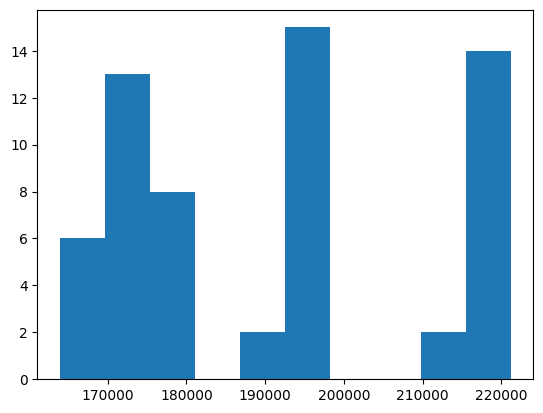

In [45]:
plt.hist(inds1)

# Extracting HTML Chunks

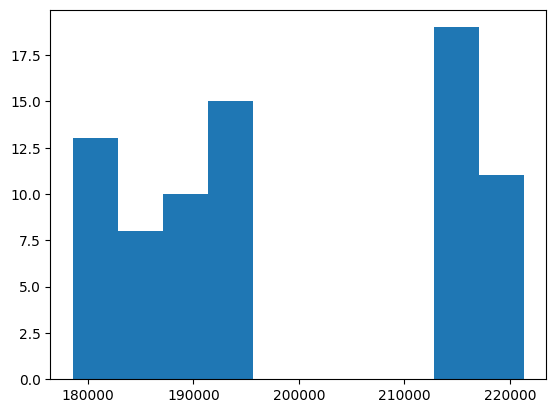

In [13]:
x, bins, p = plt.hist(inds1)
sum_norm = x/max(x)
chosen = [count for count, i in enumerate(sum_norm) if i >= 0.7]
chosen_inds = [inds1[i] for i in chosen]

In [21]:
allhtml = str(html)
for i in chosen_inds:
    count = i
    while (count < len(allhtml)-1):
        if allhtml[count] == "\\" and allhtml[count+1] == ">":
            print(count)
            break

        count += 1

    

In [61]:
spacing = 40

for i in inds1:
    print(allhtml[i - spacing : i + spacing])
    print("seperator")
    print("")


":{"alt":"boxbox Oversized T-shirt Lewis Hamilton Sketch - boxbox","id":35646253
seperator

:{"alt":"boxbox Oversized T-shirt Lewis Hamilton Sketch - boxbox","id":356462535
seperator

ch - boxbox","id":35646253596824,"position":2,"preview_image":{"aspect_ratio":0.
seperator

":35646253596824,"position":2,"preview_image":{"aspect_ratio":0.667,"height":216
seperator

"preview_image":{"aspect_ratio":0.667,"height":2160,"width":1440,"src":"\\/\\/bo
seperator

_ratio":0.667,"height":2160,"width":1440,"src":"\\/\\/boxbox.in\\/cdn\\/shop\\/f
seperator

uct-form-template--15932203434136__main" accept-charset="UTF-8" class="form" enc
seperator

15932203434136__main" accept-charset="UTF-8" class="form" enctype="multipart/for
seperator

             Refresh\n            </button>\n          </div>\n        </pickup-
seperator

 </div>\n        </pickup-availability-preview>\n      </template>\n    </pickup
seperator

pickup-availability-preview>\n      </template>\n    </pickup-availability>\n\n 

In [76]:
soup = BeautifulSoup(html)


<!DOCTYPE html>

<html class="no-js" lang="en">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width,initial-scale=1" name="viewport"/>
<meta content="" name="theme-color"/>
<link href="https://boxbox.in/products/copy-of-boxbox-oversized-t-shirt-44-lewis-hamilton-1" rel="canonical"/><link href="//boxbox.in/cdn/shop/files/favicon2-01.png?crop=center&amp;height=32&amp;v=1689155565&amp;width=32" rel="icon" type="image/png"/><link crossorigin="" href="https://fonts.shopifycdn.com" rel="preconnect"/><title>
      boxbox Oversized T-shirt Lewis Hamilton Sketch
</title>
<meta content="This Oversized T-shirt from boxbox features a sketch of seven-time Formula One world champion Sir Lewis Hamilton. Comfortable and stylish, this exclusive design is the perfect way to showcase your admiration for F1's most successful driver. FREE SHIPPING across INDIA! Good to know:  Unisex t-shirt pattern with a loose " name="description"/>
<meta

# Text Similarities

In [65]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
from sentence_transformers import SentenceTransformer, util

def text_similarity(text1, text2):
    # Tokenize and lemmatize the texts
    tokens1 = word_tokenize(text1)
    tokens2 = word_tokenize(text2)
    lemmatizer = WordNetLemmatizer()
    tokens1 = [lemmatizer.lemmatize(token) for token in tokens1]
    tokens2 = [lemmatizer.lemmatize(token) for token in tokens2]

    # Remove stopwords
    stop_words = stopwords.words('english')
    tokens1 = [token for token in tokens1 if token not in stop_words]
    tokens2 = [token for token in tokens2 if token not in stop_words]

    # Create the TF-IDF vectors
    vectorizer = TfidfVectorizer()
    vector1 = vectorizer.fit_transform(tokens1)
    vector2 = vectorizer.transform(tokens2)

    # Calculate the cosine similarity
    similarity = cosine_similarity(vector1, vector2)

    return similarity


text_similarity(allhtml, parts[0])

import transformers

# Load the RoBERTa model
# model = transformers.RobertaModel.from_pretrained('roberta-base')

# Tokenize and encode the texts
# text1 = allhtml
# text2 = parts[0]
# encoding1 = model.encode(text1, max_length=512)
# encoding2 = model.encode(text2, max_length=512)
# encoding1 = model(text1)["input_ids"]

model = SentenceTransformer('sentence-transformers/all-roberta-large-v1')




def bert_sim(text1, text2):
    embeddings = model.encode([text1,text2])
    res = util.pytorch_cos_sim(embeddings[0], embeddings[1])
    return res.numpy()[0][0] 


bert_sim('Home  Formula 1             Formula 1  T-shirts Oversized T-shirts Sweatshi', parts[0])
# bert_sim('cdn.com" crossorigin><title>\\n      boxbox Oversized T-shirt Lewis Hamilton', ' Home, Formula 1, Football, Contact, About Us, Blogs, Smiles, Log in, Cart\n')

# Calculate the cosine similarity between the embeddings
# similarity = np.dot(encoding1, encoding2) / (np.linalg.norm(encoding1) * np.linalg.norm(encoding2))
# print(similarity)


0.57481945

In [73]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Convert the texts into TF-IDF vectors

def sim(text1, text2):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([text1, text2])

    # Calculate the cosine similarity between the vectors
    similarity = cosine_similarity(vectors)
    return similarity

In [167]:
# l = len(parts[0])
# res = []
# vals = []
# for i in range(len(readableText) - l):
#     em = bert_sim(readableText[i:i+l], parts[0])
#     res.append(em)
#     vals.append(allhtml[i:i+l])


l = len(parts[0])
res = []
vals = []
for i in elements:
    em = bert_sim(i.text, parts[0])
    res.append(em)
    vals.append(i.text)



In [175]:
# res = [i.numpy()[0][0] for i in res]

counts = [count for count, i in enumerate(res) if i > 0.3]
[elements[i].parent for i in counts]
# counts
# parts[0]

# allhtml.find('Home')
# readableText[456 : 456 + len(parts[0])]


[<summary class="menu-drawer__menu-item list-menu__item link link--text focus-inset" id="HeaderDrawer-formula-1">
                         Formula 1
                         <svg aria-hidden="true" class="icon icon-arrow" fill="none" focusable="false" viewbox="0 0 14 10" xmlns="http://www.w3.org/2000/svg">
 <path clip-rule="evenodd" d="M8.537.808a.5.5 0 01.817-.162l4 4a.5.5 0 010 .708l-4 4a.5.5 0 11-.708-.708L11.793 5.5H1a.5.5 0 010-1h10.793L8.646 1.354a.5.5 0 01-.109-.546z" fill="currentColor" fill-rule="evenodd">
 </path></svg>
 <svg aria-hidden="true" class="icon icon-caret" focusable="false" viewbox="0 0 10 6">
 <path clip-rule="evenodd" d="M9.354.646a.5.5 0 00-.708 0L5 4.293 1.354.646a.5.5 0 00-.708.708l4 4a.5.5 0 00.708 0l4-4a.5.5 0 000-.708z" fill="currentColor" fill-rule="evenodd">
 </path></svg>
 </summary>,
 <button aria-expanded="true" class="menu-drawer__close-button link link--text focus-inset">
 <svg aria-hidden="true" class="icon icon-arrow" fill="none" focusable="false"

3183